# Simple Adeversarial Code.

If the score (roc auc) of this model is around 0.5, we can colclude that the distribution of features between train and test data is very similar

In [42]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import lightgbm as lgb

In [2]:
sys.path.insert(0, "/opt/vssexclude/personal/kaggle/kaggle_tab_mar/src")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import munging.process_data_util as process_data
import common.com_util as util
import config.constants as constants

In [5]:
logger = util.get_logger('main')

In [6]:
train_df, test_df, _ = process_data.read_processed_data(logger,
                                                     constants.PROCESSED_DATA_DIR,
                                                     train=True,
                                                     test=True,
                                                     sample_submission=False)

train_df.shape, test_df.shape

[INFO]2021-03-11 14:47:41,547:main:Reading Data from /opt/vssexclude/personal/kaggle/kaggle_tab_mar/data/processed...
[INFO]2021-03-11 14:47:41,644:main:Shape of train_df : (300000, 31)
[INFO]2021-03-11 14:47:41,679:main:Shape of test_df : (200000, 30)


((300000, 31), (200000, 30))

In [7]:
# Decide the predictors
features = test_df.columns

# Create the train & test data for adversarial validation
train_df = train_df[features]
# Create a dummy target to separate out train and test data
train_df["target"] = 0
test_df["target"] = 1

train_test_df = pd.concat([train_df, test_df], axis=0)

In [8]:
# Confirm the target distribution in train_test_df
train_test_df.target.value_counts()

0    300000
1    200000
Name: target, dtype: int64

In [9]:
# Label encode categorical features
cat_features = [name for name in features if 'cat' in name]

for name in cat_features:
    le = LabelEncoder()
    le.fit(train_test_df[name])
    train_test_df[name] = le.transform(train_test_df[name])

In [13]:
# Create train & validation data set to validate the model built for adversarial validation
train_df, validation_df = train_test_split(train_test_df, test_size=0.33, random_state=42, shuffle=True)

train_df.shape, validation_df.shape

((335000, 31), (165000, 31))

In [14]:
# To be on the safer side, check target value distribution in train_df
train_df.target.value_counts()

0    201000
1    134000
Name: target, dtype: int64

In [15]:
# To be on the safer side, check target value distribution in train_df
validation_df.target.value_counts()

0    99000
1    66000
Name: target, dtype: int64

In [16]:
# id should be mixed up
train_df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
308547,1,8,3,1,4,33,0,19,38,0,...,0.199874,0.667637,0.347652,0.733776,0.226715,0.683053,0.486450,0.301790,0.436562,1
356585,0,6,6,1,3,33,7,39,48,0,...,0.329803,0.584787,0.578935,0.418120,0.467397,0.533833,0.411339,0.719804,0.511533,0
26290,1,8,0,1,4,2,0,14,13,0,...,0.254874,0.309040,0.292972,0.293131,0.678089,0.263619,0.330077,0.239734,0.314284,1
23025,0,7,14,0,4,69,2,11,38,0,...,0.297880,0.334087,0.462165,0.272757,0.407102,0.259435,0.360080,0.261884,0.462042,1
115407,1,10,0,0,4,33,2,19,38,5,...,0.307156,0.315753,0.352470,0.734848,0.594551,0.385752,0.386277,0.548261,0.267465,0


In [18]:
# ids should be mixed up
validation_df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,
174138,0,5,0,0,4,33,2,9,55,2,...,0.541051,0.657140,0.470970,0.620552,0.569496,0.552985,0.458565,0.468596,0.689696,0
333235,1,5,0,0,4,33,2,30,38,8,...,0.342121,0.275492,0.784097,0.557006,0.592018,0.545133,0.372315,0.480407,0.323813,0
233842,0,8,0,0,5,33,0,6,28,5,...,0.371414,0.558232,0.208408,0.168313,0.521958,0.566209,0.507267,0.360524,0.543451,0
221699,1,10,0,1,4,33,0,39,5,4,...,0.532820,0.548292,0.496403,0.122048,0.184388,0.529037,0.693064,0.318731,0.523785,0
271550,1,8,3,0,4,33,2,16,38,0,...,0.390959,0.317699,0.338363,0.555064,0.556805,0.385767,0.360034,0.320340,0.513304,1


In [27]:
# Create X & y for the model
train_y = train_df['target'].values
validation_y = validation_df['target'].values

train_X = train_df.drop(['target'], axis=1)
valid_X = validation_df.drop(['target'], axis=1)

lgb_train = lgb.Dataset(train_X, label=train_y)
lgb_validation = lgb.Dataset(valid_X, label=validation_y)

In [28]:
# Deafult params
lgb_params = {
                'objective': 'binary',
                'boosting_type': 'gbdt',
                'n_jobs': -1,
                'seed': 42,
                'metric': 'auc',
                'verbose': -1,
                }

In [30]:
model = lgb.train(lgb_params, 
                  lgb_train,
                  num_boost_round=1000,
                  valid_sets=[lgb_train, lgb_validation],
                  verbose_eval=20, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[20]	training's auc: 0.540632	valid_1's auc: 0.499193
[40]	training's auc: 0.560208	valid_1's auc: 0.498492
[60]	training's auc: 0.57662	valid_1's auc: 0.498176
[80]	training's auc: 0.589536	valid_1's auc: 0.499279
[100]	training's auc: 0.601028	valid_1's auc: 0.498402
Early stopping, best iteration is:
[1]	training's auc: 0.503927	valid_1's auc: 0.500776


In [32]:
fe_importance = pd.DataFrame()
fe_importance["feature"] = features
fe_importance["importance"] = model.feature_importance()
fe_importance.sort_values(by=["importance"], ascending=False, inplace=True)
fe_importance.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Feature Importance')

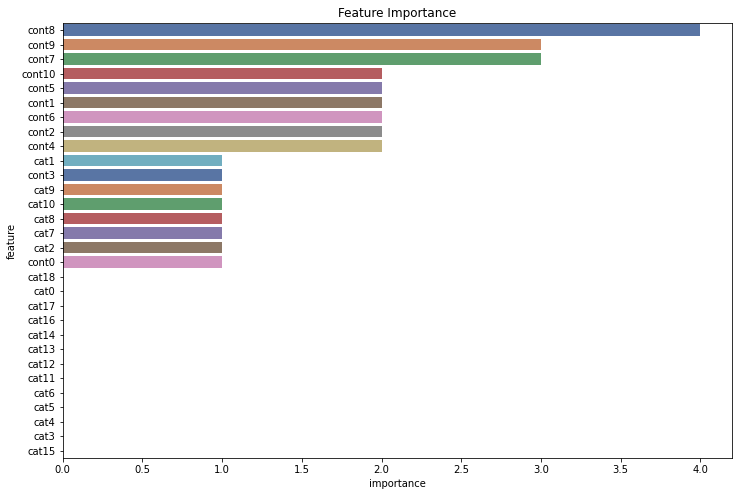

In [51]:
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=fe_importance, palette="deep")
plt.title("Feature Importance")